# Chapter 3: Classification on the MNIST dataset

In [1]:
import numpy as np

SKL has functions to download popular datasets, including MNIST.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',


Can see that the `mnist` variable is a `dict`, with the keys shown above. This gives some insight into what each of the values corresponding to the keys contains.

In [4]:
X, y = mnist["data"], mnist["target"]
print(f"X: type {type(X)}, shape {X.shape}")
print(f"y: type {type(y)}, shape {y.shape}")

X: type <class 'numpy.ndarray'>, shape (70000, 784)
y: type <class 'numpy.ndarray'>, shape (70000,)


- 70 k data points/observations, with labels
- Each observation has 784 features

From what we know about this dataset, each image is 28 x 28 pixels (784 total) and each feature represents the intensity of the greyscale pixel from 0 (white) to 255 (black)

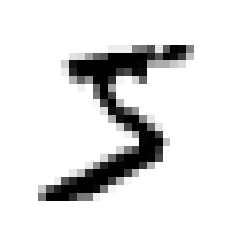

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]  # first observation
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")  # Plot interpreting matrix as 2D array of pixels. `cmap` is colour map, with binary being greyscale with 0=white to 255=black
plt.axis("off")
plt.show()

Check the label

In [6]:
y[0]

'5'

In [7]:
np.unique(y)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

Labels are strings, but we'll need them as numbers to work wtih the ML algorithm

In [8]:
y = y.astype(np.uint8)  # unsigned 8-bit int

## Train/test set split

MNIST already configured into train/test sets. First 60 k images are train, last 10 k are test. Observations are already shuffled with even distribution, so no concerns about ordering or lack of digits in possible CV folds.

In [9]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

## Binary classifier: 5 or not-5

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [11]:
print(y_train[:20])
print(y_train_5[:20])

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
[ True False False False False False False False False False False  True
 False False False False False False False False]


#### Quick training: SGD classifier

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])  # `predict()` method needs to be passed a list of features

array([ True])

Correctly predicts true for the first digit, which we know is a 5 from above

#### Evaluation of binary classifier
Using K-fold CV with 3 folds

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Using "dumb" classifier, just makes everything `False`, i.e. not-5

In [15]:
from sklearn.base import BaseEstimator  # Basic SKL estimator foundation class. Inherit from this.

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):  # Do nothing/dummy method. Required so can use this estimator in the `cross_val_score()` function.
        pass
    
    def predict(self, X,):
        return np.zeros((len(X), 1), dtype=bool)  # Always predict `False`


In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")  # Accuracy is ratio of correct predictions / all predictions = (TP + TN) / (TP + TN + FP + FN)

array([0.91125, 0.90855, 0.90915])

Approx. 90 per cent accuracy always guessing false, since only approx. 10 per cent of all observations are digit 5.

**Confusion matrix**

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

**Precision and recall**

In [19]:
from sklearn.metrics import precision_score, recall_score

print(f"Precison = {precision_score(y_train_5, y_train_pred)}")  # when predict positive, how often are you correct?
print(f"Recall =   {recall_score(y_train_5, y_train_pred)}")     # when actually positive, how often are you correct?

Precison = 0.8370879772350012
Recall =   0.6511713705958311


Somewhat conservative. It's guessing `False` more often than it should, making it more confident when it actually does say `True`.

**F1 score: Harmonic mean of precision and recall**

Favours classifiers with similar values for these measures. Pulled towards lower/lesser of the two (since it's a harmonic mean).

In [20]:
from sklearn.metrics import f1_score

print(f"F1 score = {f1_score(y_train_5, y_train_pred)}")

F1 score = 0.7325171197343846


**Changing the decision threshold**

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [22]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

That's the default threshould used by `SGDClassifier`. But if we change it to 8000 say:

In [23]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Then it predicts `not-5`. Which will mean less TP and FP (more conservative at guessing P -> higher precision), and more TN and FN (less often correct when actually positive -> lower recall).

So, **raising the threshold increases precision at the cost of lowering recall**.

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")  # This method means return only the decision scores, don't make a prediction

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)  # precision and recall calculated as function of thresholds

thresholds

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

`thresholds` must have some defined min, max and delta

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve

>thresholdsarray, shape = [n_thresholds <= len(np.unique(probas_pred))]
Increasing thresholds on the decision function used to compute precision and recall.

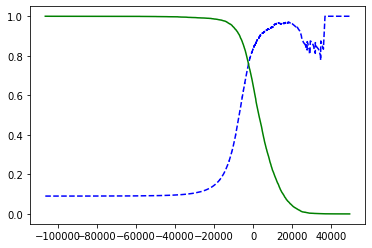

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Note that precision **can go down as the threshold is increased**, which provides for a secion of these plots that are bumpy/not smooth.

Recall is always smooth and can only operate inversely to threshold.

Let's have a look at **plotting precision (y-axis) vs recall (x-axis)**, parameterised by the threshold

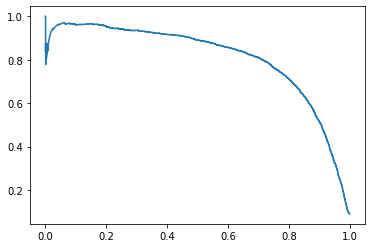

In [27]:
plt.plot(recalls, precisions)
plt.show()

**It's a trade-off.** Can pretty much choose any precision you want, by modifying the threshold, but you cop whatever the corresponding recall is (or vice-versa).

True increases in "performance" are about creating a better model that has a better trade-off curve.

#### ROC curve

TPR (sensitivity) vs the FPR (1 - specificity, where specificity is the TNR)

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

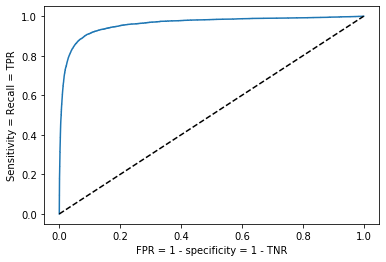

In [29]:
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # from x=0, y=0 to x=1, y=1
plt.xlabel("FPR = 1 - specificity = 1 - TNR")
plt.ylabel("Sensitivity = Recall = TPR")
plt.show()

Trade off apparent again: More TP mean more FP

Makes sense. The more *sensitive* the model, the better it is at picking TP, but also increases the rate of incorrectly saying True and giving a FP.

**Area under curve: ROC AUC**

Perfect = 1

Random guessing = 0.5

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)  # Needs the scores so can vary the thresholds to calc the ROC curve and hence determine the AUC

0.9604938554008616

#### Random Forest classifier

Doesn't have a `decision_function()` method. Instead has a `predict_proba()` method.

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")  # Doesn't do accuracy or other measure, instead returns probabilities row belongs to class

Note how the results are probabilities of being not-5 (negative class) or 5 (positive class), and these sum to 1:

In [32]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

Scores can be the probabilities of being 5 (positve class), the second column (remember Python is 0-indexed)

In [33]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

`roc_curve` can then be calculated using these scores/probabilities

In [34]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

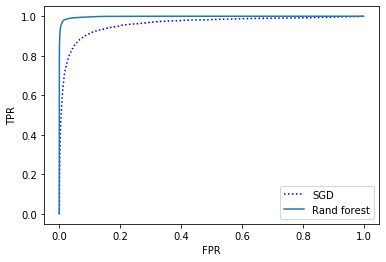

In [35]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Rand forest")
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

In [36]:
sgd_clf.decision_function

0.9983436731328145

## Multiclass classification

Now going to try to classify each digit into its own category: going beyond 5 or not-5 binary classification.

#### Exploring *One-vs-Rest (OvR)* and *One-vs-One (OvO)*, in using binary classifiers for multiclass problems.

In [38]:
from sklearn.svm import SVC

svm_clf = SVC()  # Linear support vector machine classifier, binary classifier that defaults to OvO for mutliclass
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [42]:
np.argmax(some_digit_scores)  # Picks the 5, but only just. High scores on many other classes too.

5

The classification classes are saved to a convenience variable `classes_` within the predictor object

In [43]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Forcing OvR (similar to force OvO if you want to). Create a class and pass the predictor for the classifer to its constructor:

In [44]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
ovr_clf.estimators_  # Can see there are 10 binary estimators/predictors, since this is OvR

[SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.0

#### Natural multiclass classifier: SGD

In [63]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

In [55]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
sgd_clf.decision_function([some_digit])

array([[-14464.07165628, -25677.40506187,  -6762.09899491,
         -4787.00810941, -12720.05340579,   -475.58306813,
        -24693.10095899, -13151.1596016 , -12073.82414716,
        -11603.83639894]])

Can evaluate using CV as before

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86005, 0.85075, 0.87965])

Accuracy can be improved by scaling the features

In [59]:
from sklearn.preprocessing import StandardScaler  # z-scaling, subtract mean and divide by std dev
scaler = StandardScaler()
X_train[0,]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [58]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_train_scaled[0,]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.41807799e-03, -5.75481961e-03, -4.08251693e-03, -4.08251693e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.08251693e-03, -4.70968827e-03, -8.79934640e-03, -1.15905591e-02,
       -1.47589798e-02, -1.92848546e-02, -2.46717975e-02, -2.90710271e-02,
       -3.05926583e-02, -3.11640127e-02, -3.19628719e-02, -3.02025355e-02,
       -3.13102175e-02, -2.83833960e-02, -2.31191906e-02, -1.91666260e-02,
       -1.67723008e-02, -1.09963601e-02, -8.32486080e-03, -4.38069356e-03,
        0.00000000e+00,  

In [ ]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

#### Error analysis on multiclass

Starting with the confusion matrix, using CV to predict on each of the folds. Note that we also display as a grey-scale shaded heatmap using Matplotlib's `matshow()` function.

In [64]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [65]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

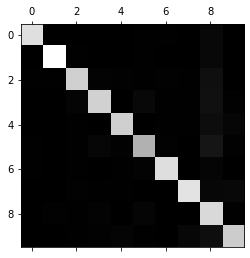

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

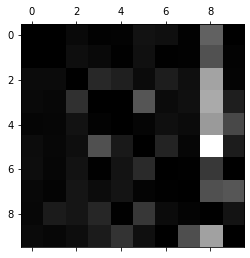

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)  # Looking only at errors, so make the correct predictions on main diagonal equal to zero

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- Clearly problems with misclassifying as 8. A "false 8" problem is our biggest concern.
- 3/5 mixed up fair bit in both directions